In [124]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class CnnPolicy(nn.Module):
    def __init__(self, ob_space, ac_space):
        super(CnnPolicy, self).__init__()
        nh, nw, nc = ob_space.shape
        nact = ac_space.n
        
        self.conv1 = nn.Conv2d(nc, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(nw))))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(nh))))
        
        linear_input_size = convw * convh * 32
        
        self.head1 = nn.Linear(linear_input_size, 16)
        self.head2 = nn.Linear(16, nact)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.head1(x))
        return self.head2(x)

In [127]:
from torchsummary import summary
summary(model.cuda(), input_size=(3, 210, 160))

torch.Size([2, 32, 10, 7])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 103, 78]             608
       BatchNorm2d-2           [-1, 8, 103, 78]              16
            Conv2d-3           [-1, 16, 50, 37]           3,216
       BatchNorm2d-4           [-1, 16, 50, 37]              32
            Conv2d-5           [-1, 32, 23, 17]          12,832
       BatchNorm2d-6           [-1, 32, 23, 17]              64
            Conv2d-7            [-1, 32, 10, 7]          25,632
       BatchNorm2d-8            [-1, 32, 10, 7]              64
            Linear-9                   [-1, 16]          35,856
           Linear-10                    [-1, 6]             102
Total params: 78,422
Trainable params: 78,422
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.66
Params si

In [126]:
import gym
env = gym.make("Pong-v0")
observation = env.reset()

model = CnnPolicy(env.observation_space, env.action_space)

for _ in range(1000):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    if done:
        observation = env.reset()
env.close()

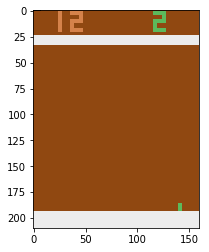

In [122]:
import matplotlib.pyplot as plt
plt.imshow(observation)

In [114]:
env.observation_space.shape

(210, 160, 3)

In [115]:
tensor = torch.tensor(np.expand_dims((observation /255.).transpose((2, 0, 1)), axis = 0))
model(tensor)

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat1' in call to _th_addmm_

In [93]:
torch.tensor(np.expand_dims((observation /255.).transpose((2, 0, 1)), axis = 0)).cuda().shape

torch.Size([1, 3, 210, 160])